In [59]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_beta_convergence

In [ ]:
clean_data = pd.read_csv(r'data\clean_data.csv')

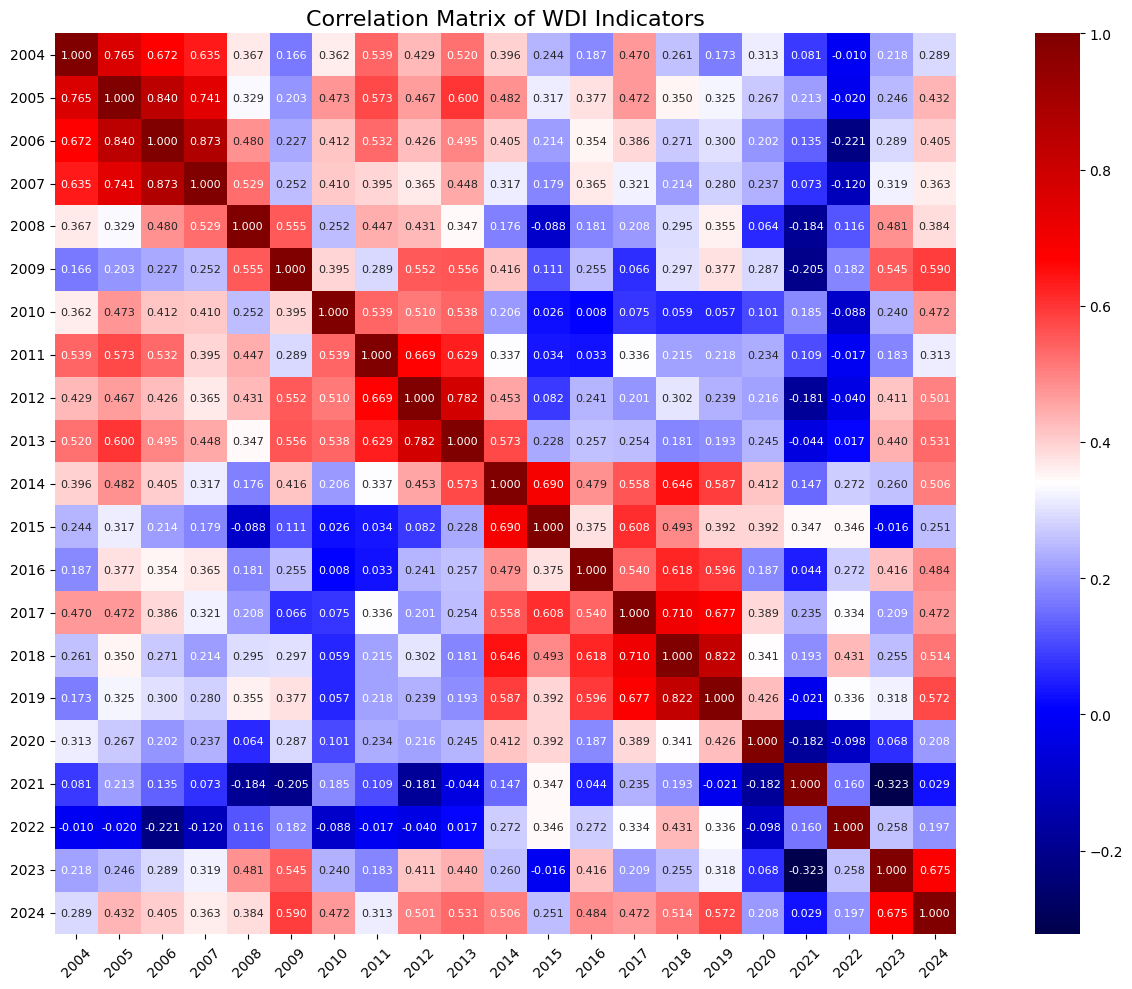

In [61]:
# correlation matrix plot
corr_matrix = clean_data.drop(['Country Code', 'Country Name', 'Pre_Crisis (2004-2008)', 
                             'Recuperation (2009-2013)', 
                             'Stability (2014-2018)', 
                             'Recent (2019-2024)', 'Group'], axis=1).corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, 
            cmap="seismic", 
            fmt=".3f",
            annot=True,
            annot_kws={"size": 8},
            square=True,
            cbar=True)
plt.title('Correlation Matrix of WDI Indicators', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

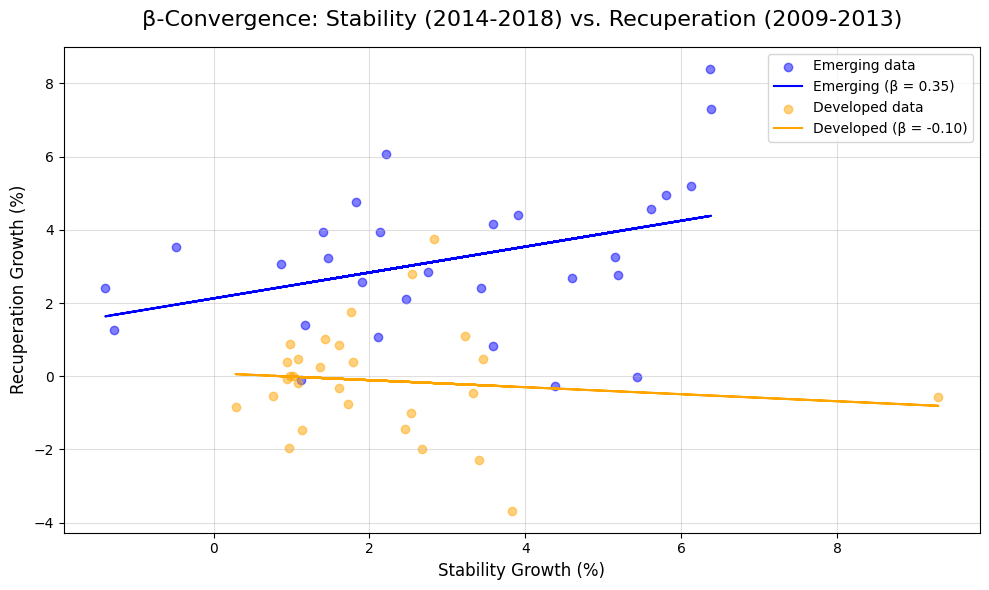

In [64]:
# First plot
plot_beta_convergence(
    clean_data, 
    'Stability (2014-2018)', 'Recuperation (2009-2013)',
    'Stability Growth (%)', 'Recuperation Growth (%)',
    'β-Convergence: Stability (2014-2018) vs. Recuperation (2009-2013)'
)

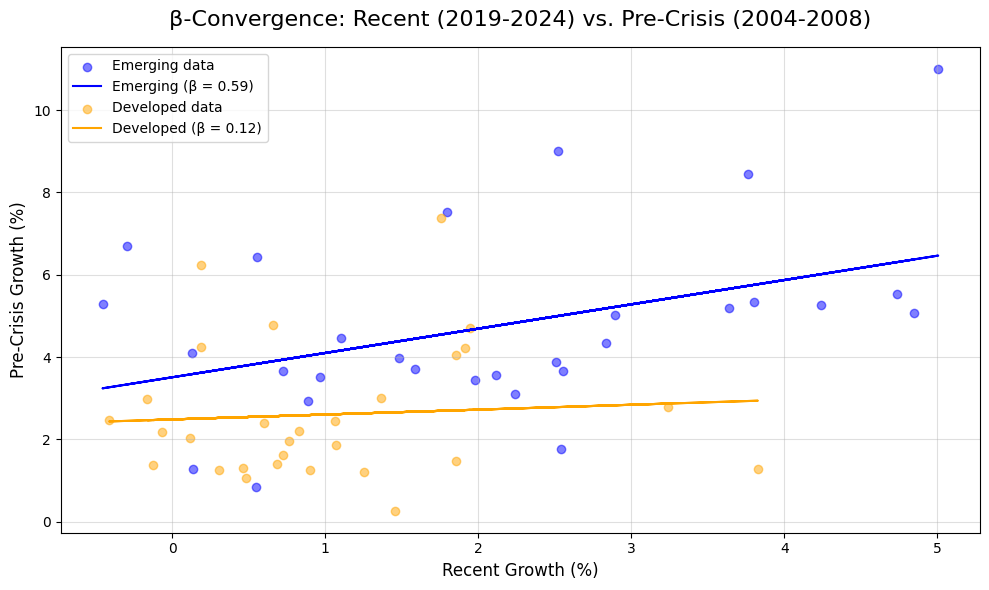

In [63]:
# Second plot
plot_beta_convergence(
    clean_data, 
    'Recent (2019-2024)', 'Pre_Crisis (2004-2008)',
    'Recent Growth (%)', 'Pre-Crisis Growth (%)',
    'β-Convergence: Recent (2019-2024) vs. Pre-Crisis (2004-2008)'
)

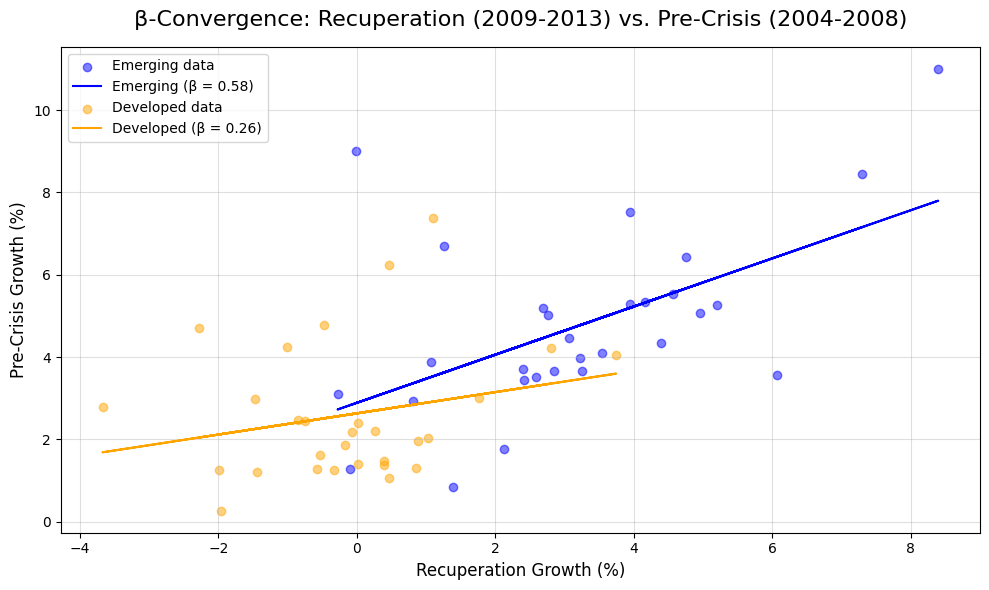

In [62]:
# Third plot
plot_beta_convergence(
    clean_data, 
    'Recuperation (2009-2013)', 'Pre_Crisis (2004-2008)',
    'Recuperation Growth (%)', 'Pre-Crisis Growth (%)',
    'β-Convergence: Recuperation (2009-2013) vs. Pre-Crisis (2004-2008)'
)